#  Прогнозирование заказов такси

На основании исторических данных о заказах такси в аэропортах, необходимо построить модель для предсказания заказов на следующий час

## Подготовка

Произведем все необходимы импорты

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib.legend import _get_legend_handles_labels
import warnings
import matplotlib.dates as mdates
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import LinearSVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
RANDOM_STATE = 42

In [2]:
warnings.filterwarnings('ignore')

Откроем и изучим файл, сразу создав индекс из первой колонки формата дата-время:

In [3]:
taxi = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
print(taxi.info())
display(taxi.head(7))

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB
None


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7


Очевидно, что пропусков в данных нет. Отсротируем данные по дате:

In [4]:
taxi.sort_index(inplace=True)
print('Данные отсротированы: ',taxi.index.is_monotonic)

Данные отсротированы:  True


Посмотрим, за какой период предоставлены данные:

In [5]:
print('Аналитический период: ', taxi.index.min(), ' - ',taxi.index.max())

Аналитический период:  2018-03-01 00:00:00  -  2018-08-31 23:50:00


Ввиду того, что нас интересует почасовое планирование, выполним ресемплирование данныех по одному часу: нас интересует общее количество заказов, так что в качестве агрегирующей функции выберем sum()

In [6]:
taxi = taxi.resample('1H').sum()


Посмотрим на получившийся график количества заказов по дням:

In [7]:
#функция для построения графиков. будем еще применять ниже
def print_plot(data,name):    
    data.plot(figsize=(12, 8))
    plt.xlabel('Временной интервал')
    plt.ylabel('Количество заказов')
    plt.title('График '+name)  
    plt.show()

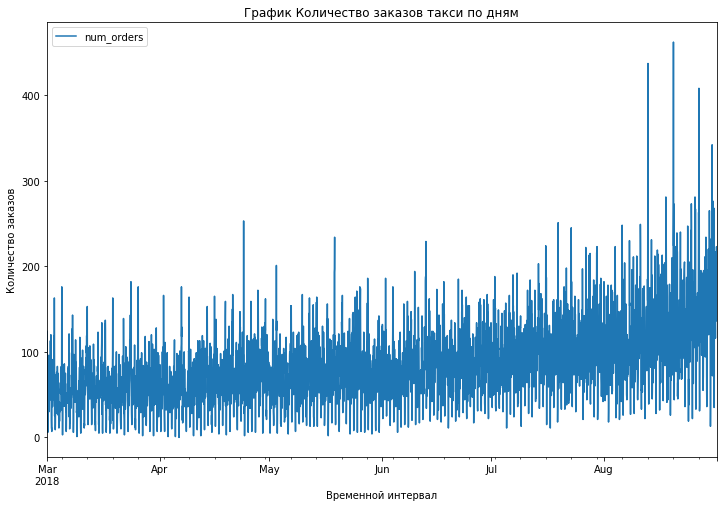

In [8]:
print_plot(taxi,'Количество заказов такси по дням')

<b>Вывод</b><br>
На графике можно видеть слабый тренд и достаточно большие колебания. Данный ряд не является стационарным. Проанализируем ряд более подробно

## Анализ

<h3>Анализ скользящего среднего и стандартного отклонения, тренда, сезонности и остатков</h3>

Посчитаем скользящее среднее и скользящее стандартное отклонение:

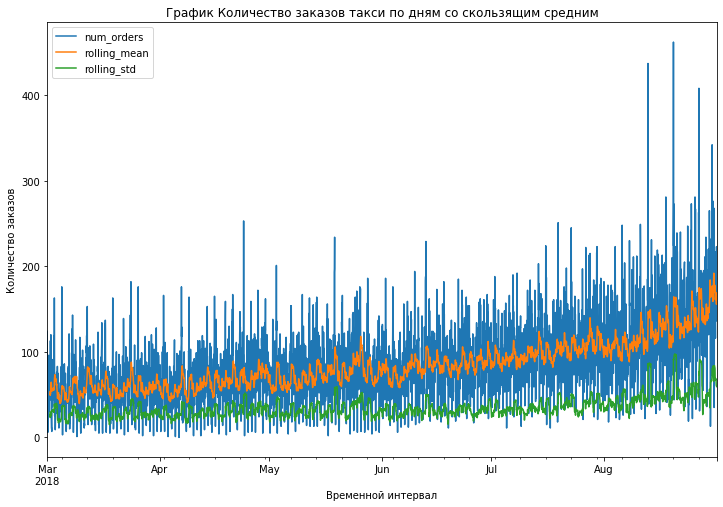

In [9]:
taxi_roll = taxi.copy()
taxi_roll['rolling_mean'] = taxi_roll['num_orders'].rolling(20).mean()
taxi_roll['rolling_std'] = taxi_roll['num_orders'].rolling(20).std()
print_plot(taxi_roll,'Количество заказов такси по дням со скользящим средним')

<b>Вывод:</b><br>
На графике скользящего среднего также виден возрастающиц тренд (с августа месяца тренд возрастает сильнее). В течение каждого месяца есть определенные колебания: резкое возрастание, потом резкое падение количества заказов, потом более плавное поведение: очень похоже на цикличность, связанную с выходными и праздничными днями. <br>
Стандартное отклонение относительно стабильно , однако можно видеть заметные колебания в августе, ближе к сентябрю. Вполне вероятно, что резко возросший сопрос на услуги такси в этот период может быть обусловлен окончанием периода отпусков и приближением учебного года.
<br>Разложим график на сезонную и трендовую составляющую, а также посмотрим более детально помесячное поведение.


In [10]:
decomposed = seasonal_decompose(taxi)

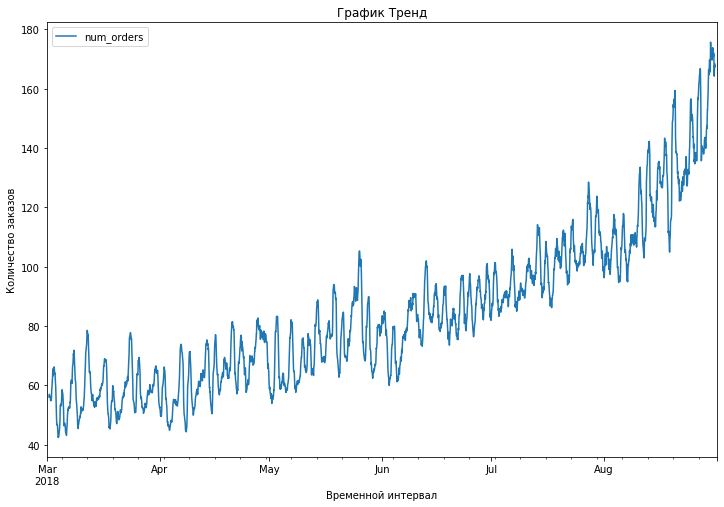

In [11]:
print_plot(decomposed.trend,'Тренд')

Можно видеть, что тренд в целом явно возрастает. Также можно видеть определенные колебания внутри каждого месяца: очень похоже на то, что они связаны с выходными и праздничными днями, но это стоит проанализировать более подробно

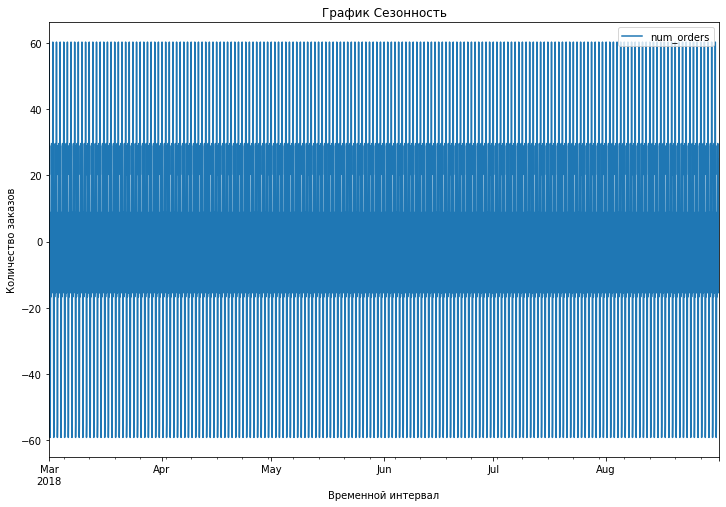

In [12]:
print_plot(decomposed.seasonal,'Сезонность')

График сезонности за весь анализируемй период может мало что сказать, однако очень похоже на ежедневную сезонность. Ниже попробуем рассмотреть помесячно и увидеть

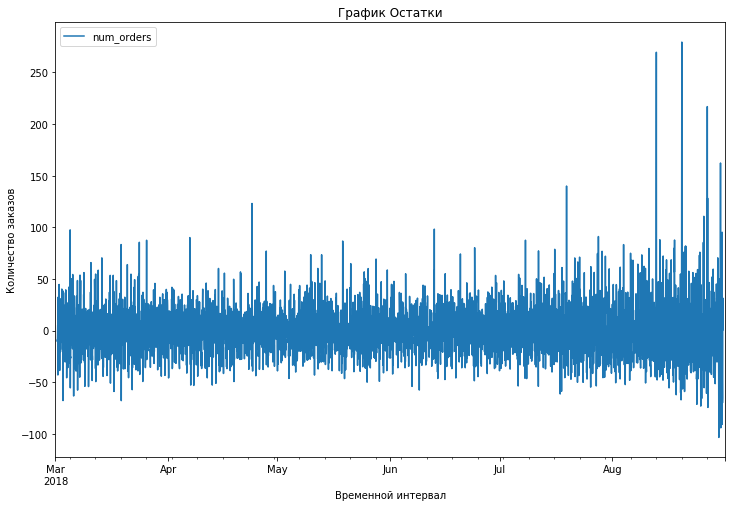

In [13]:
print_plot(decomposed.resid,'Остатки')

Можем видеть, что остатки колеблются довольно сильно, особенно силные колебания во второй половине августа

<h3>Анализ скользящего среднего и стандартного отклонения, тренда, сезонности и остатков помесячно</h3>

<b>Рассмотрим тренды, сезонность и остатки помесячно<b>

---------------------------------------------Графики для месяца:   March  --------------------------------------


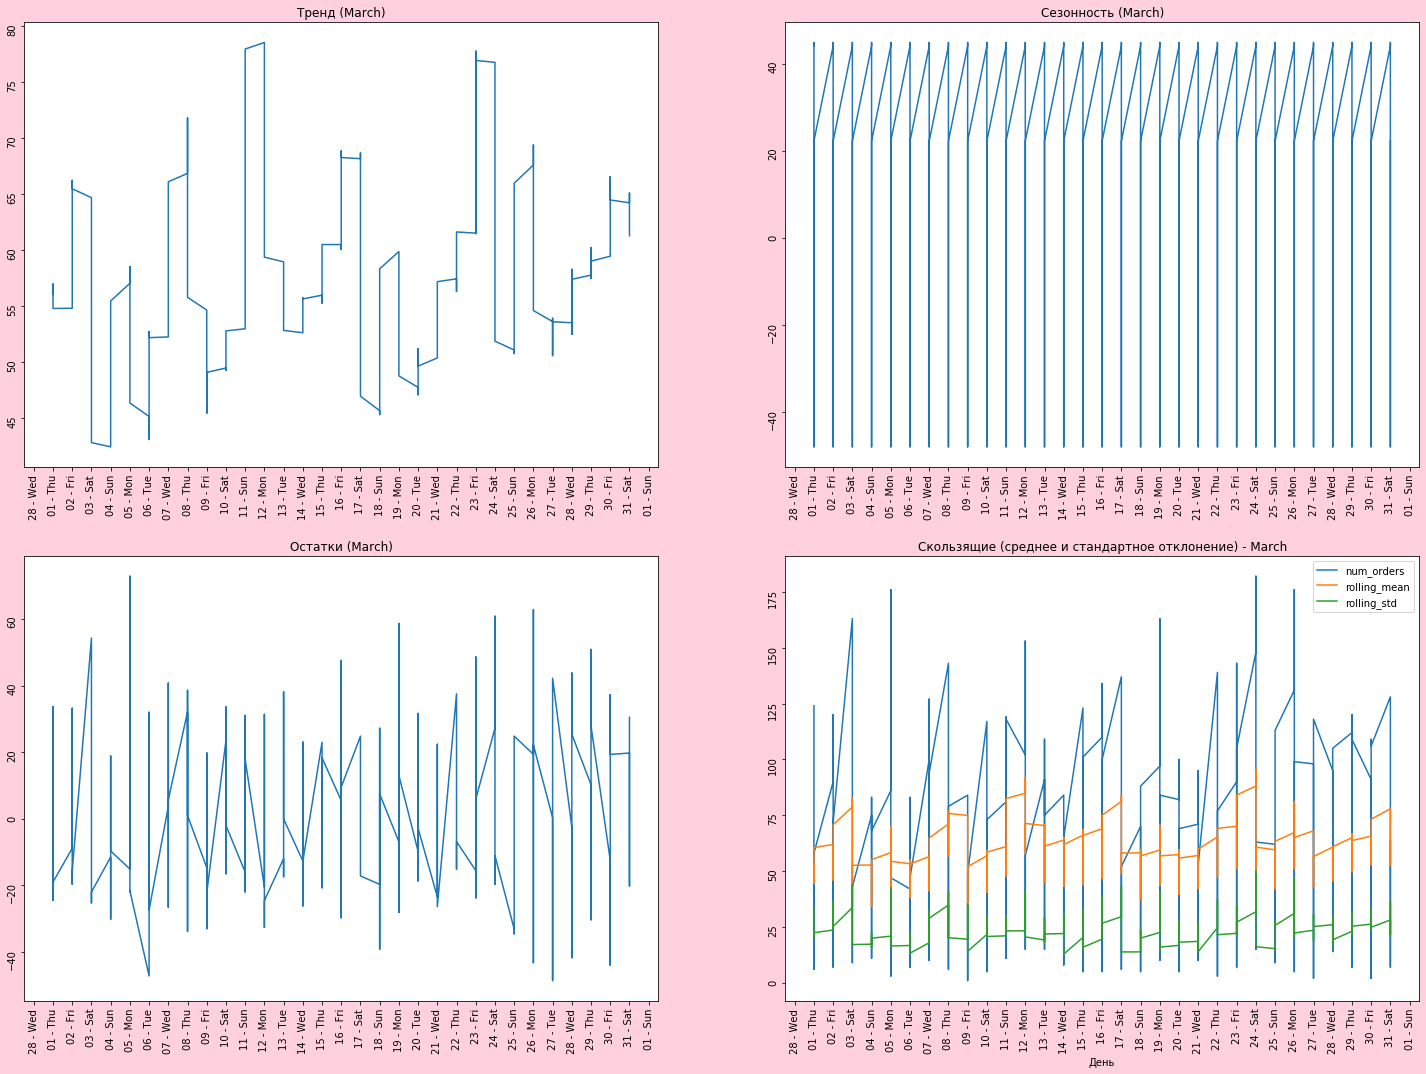

---------------------------------------------Графики для месяца:   April  --------------------------------------


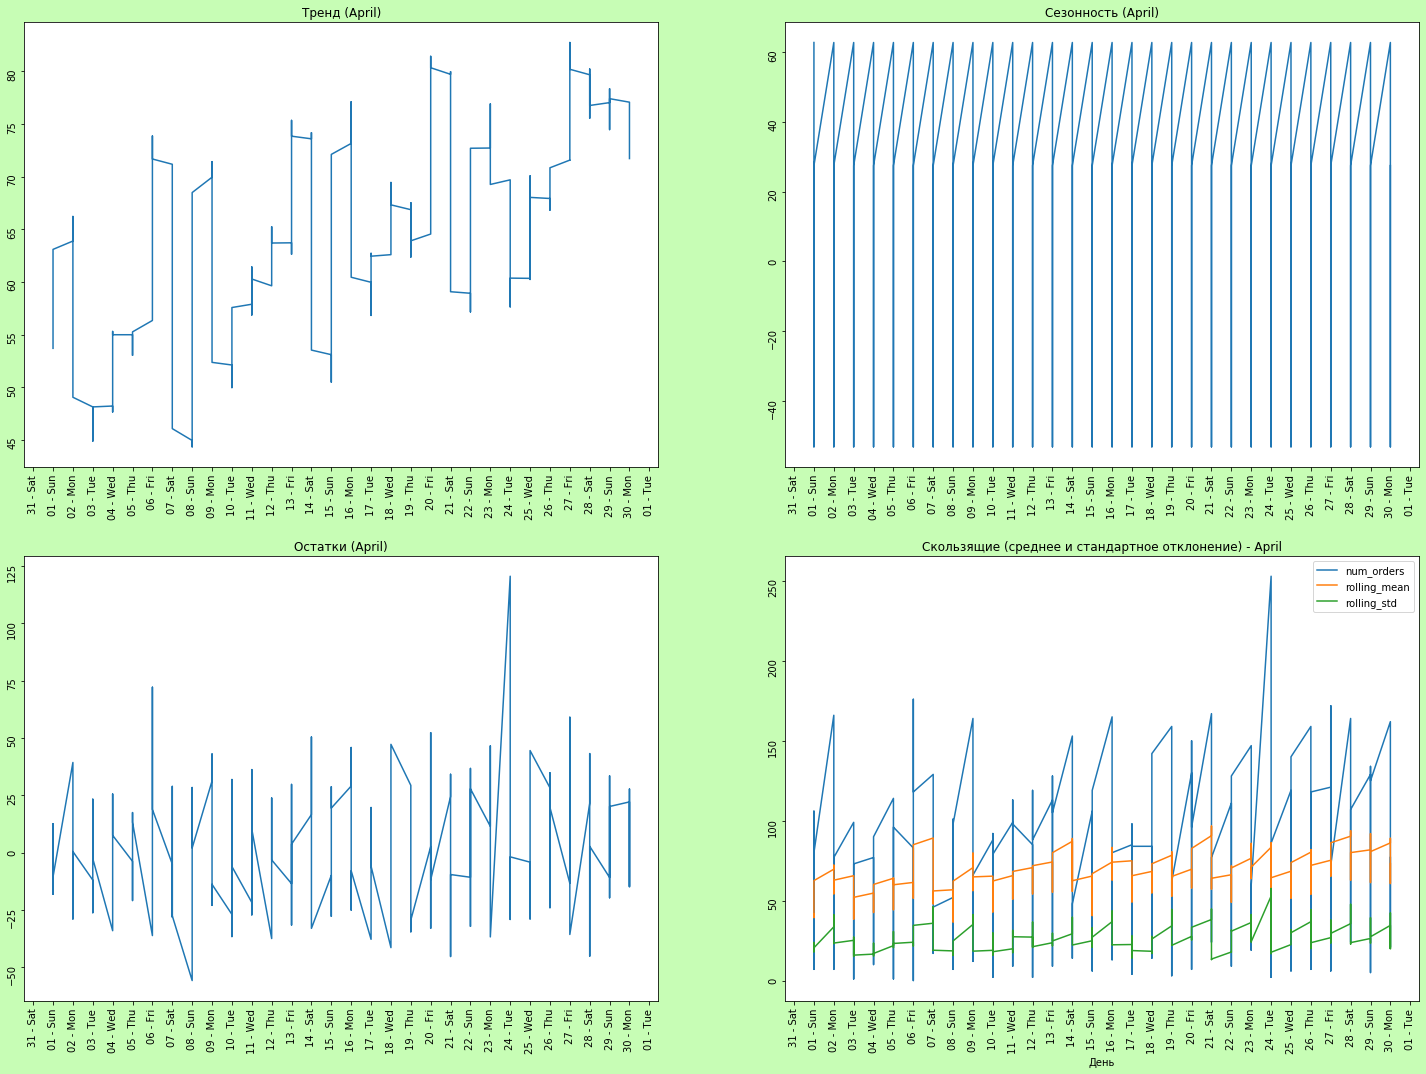

---------------------------------------------Графики для месяца:   May  --------------------------------------


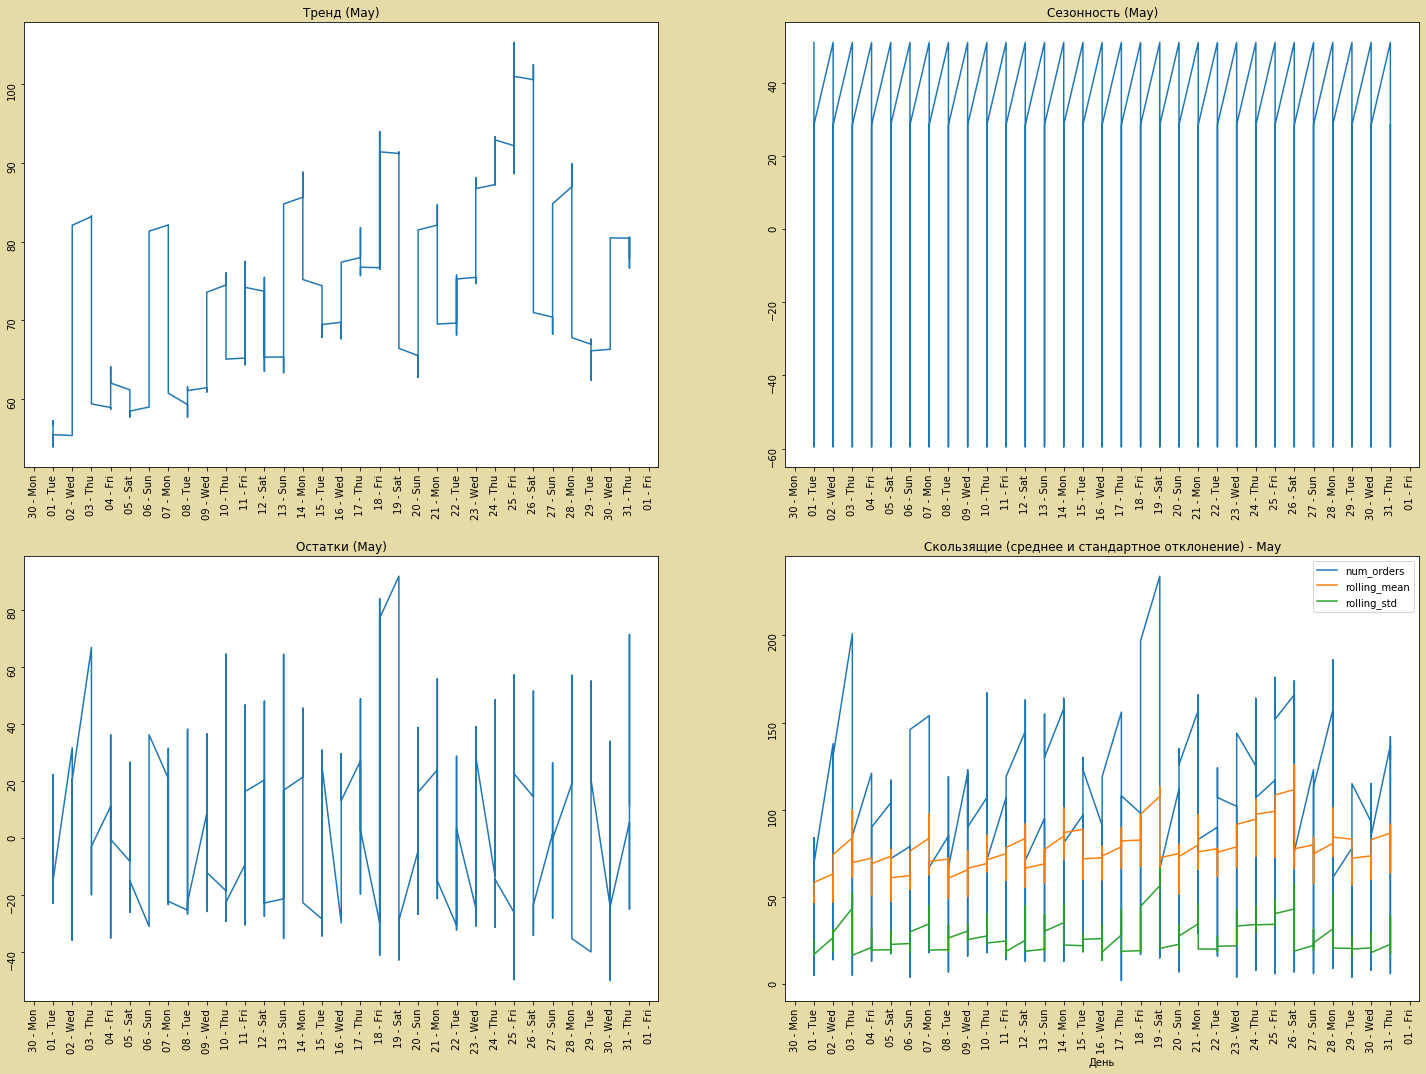

---------------------------------------------Графики для месяца:   June  --------------------------------------


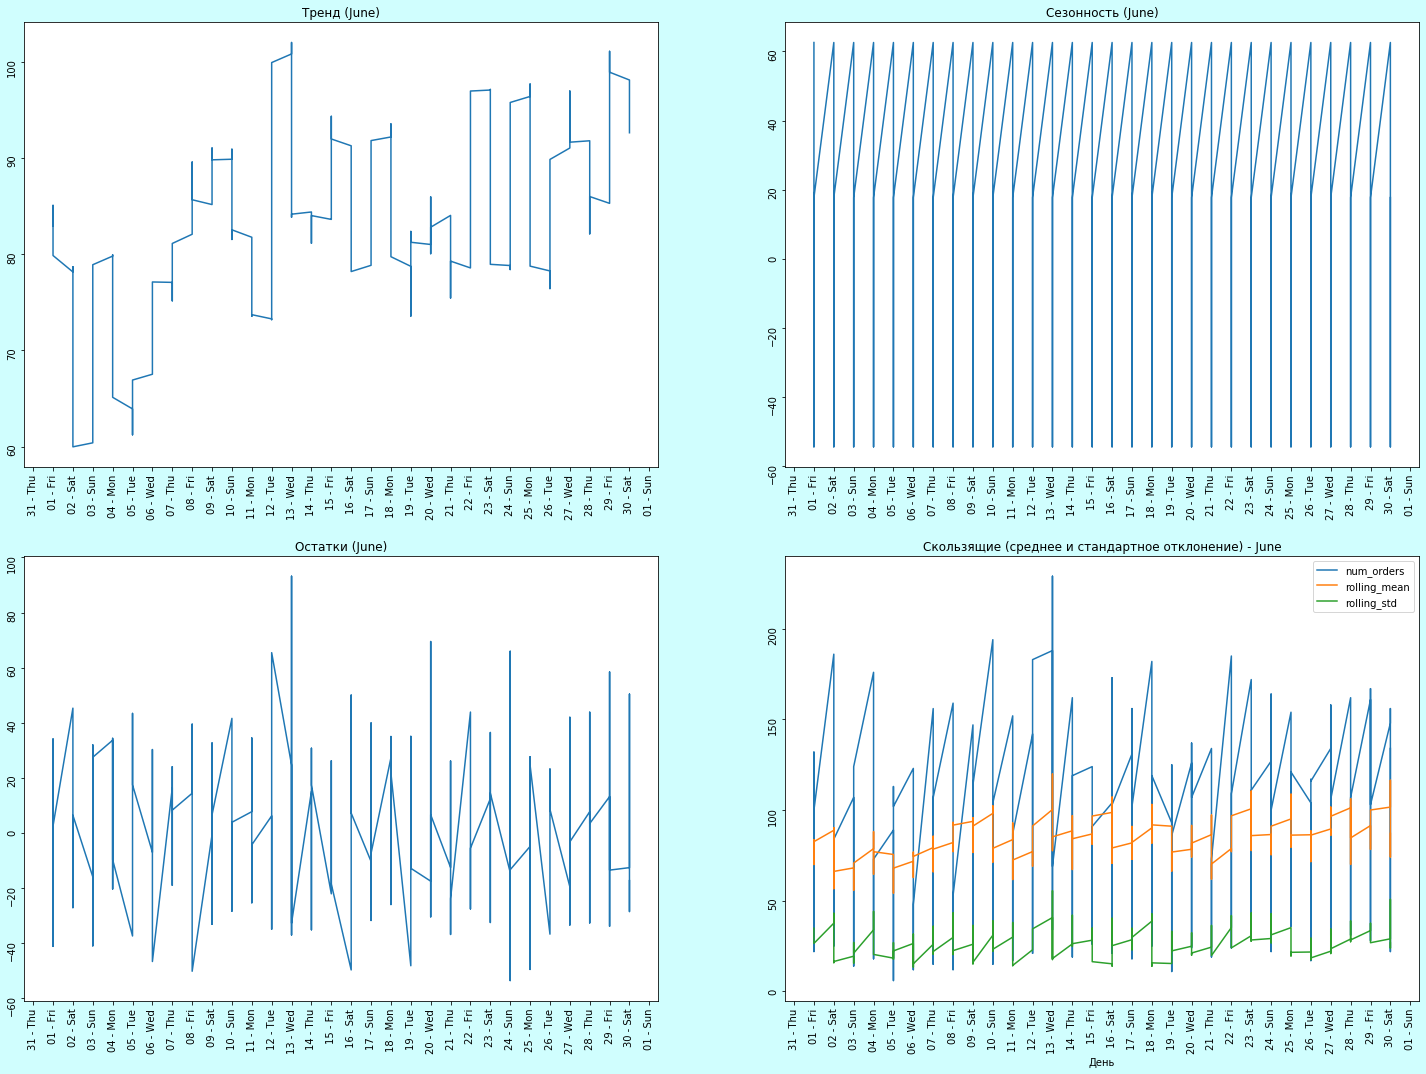

---------------------------------------------Графики для месяца:   July  --------------------------------------


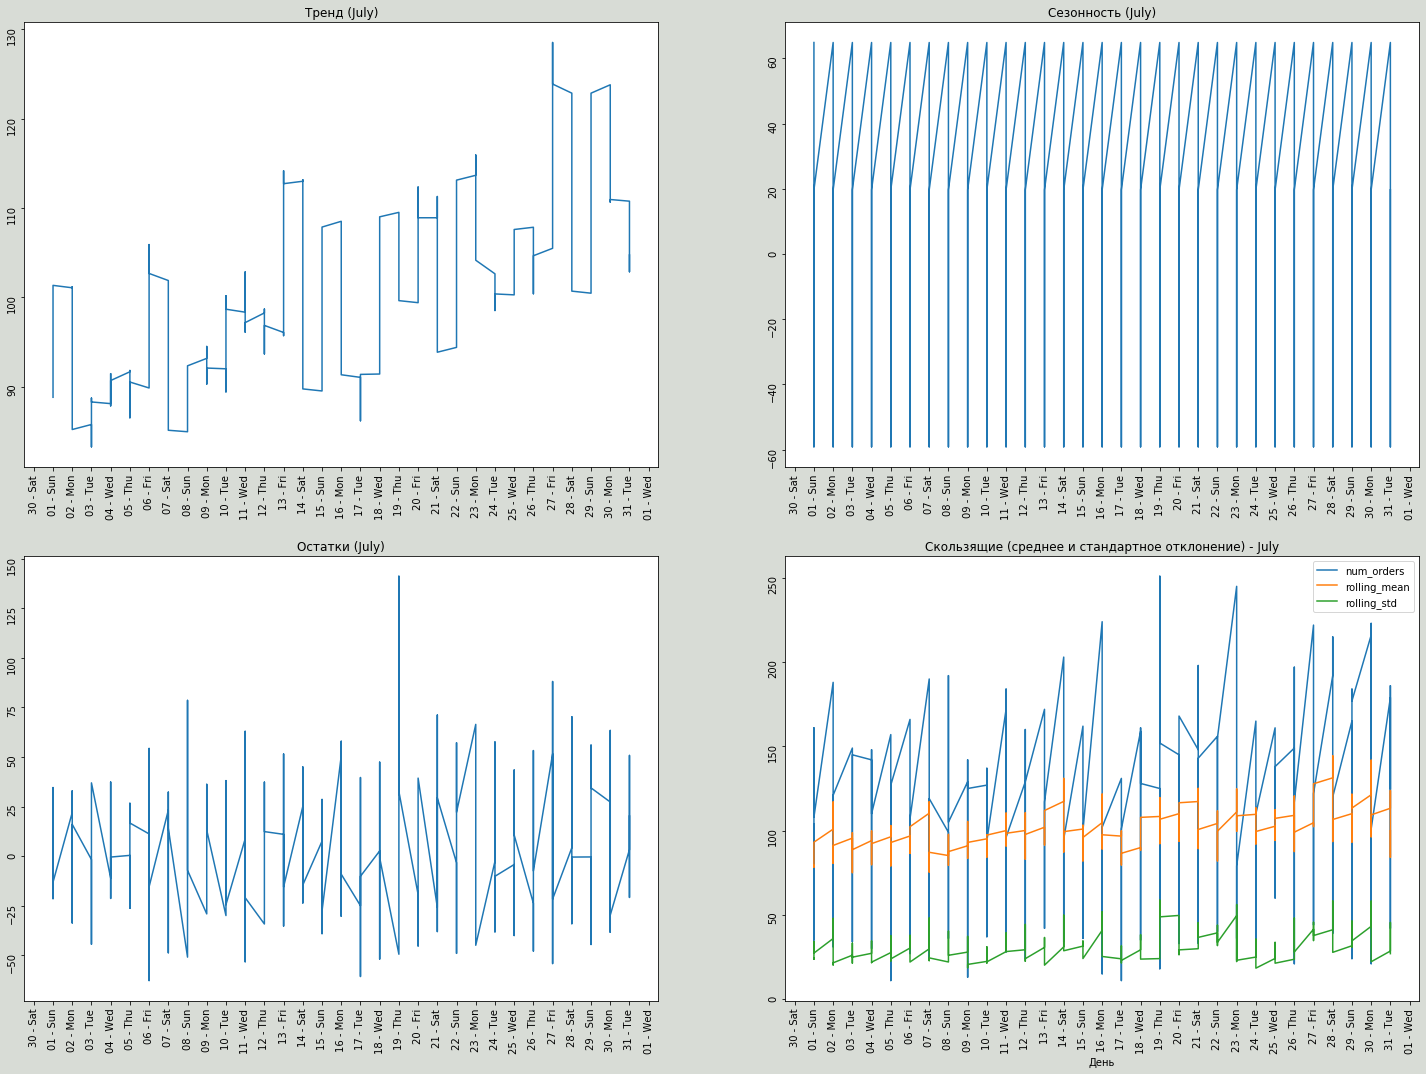

---------------------------------------------Графики для месяца:   August  --------------------------------------


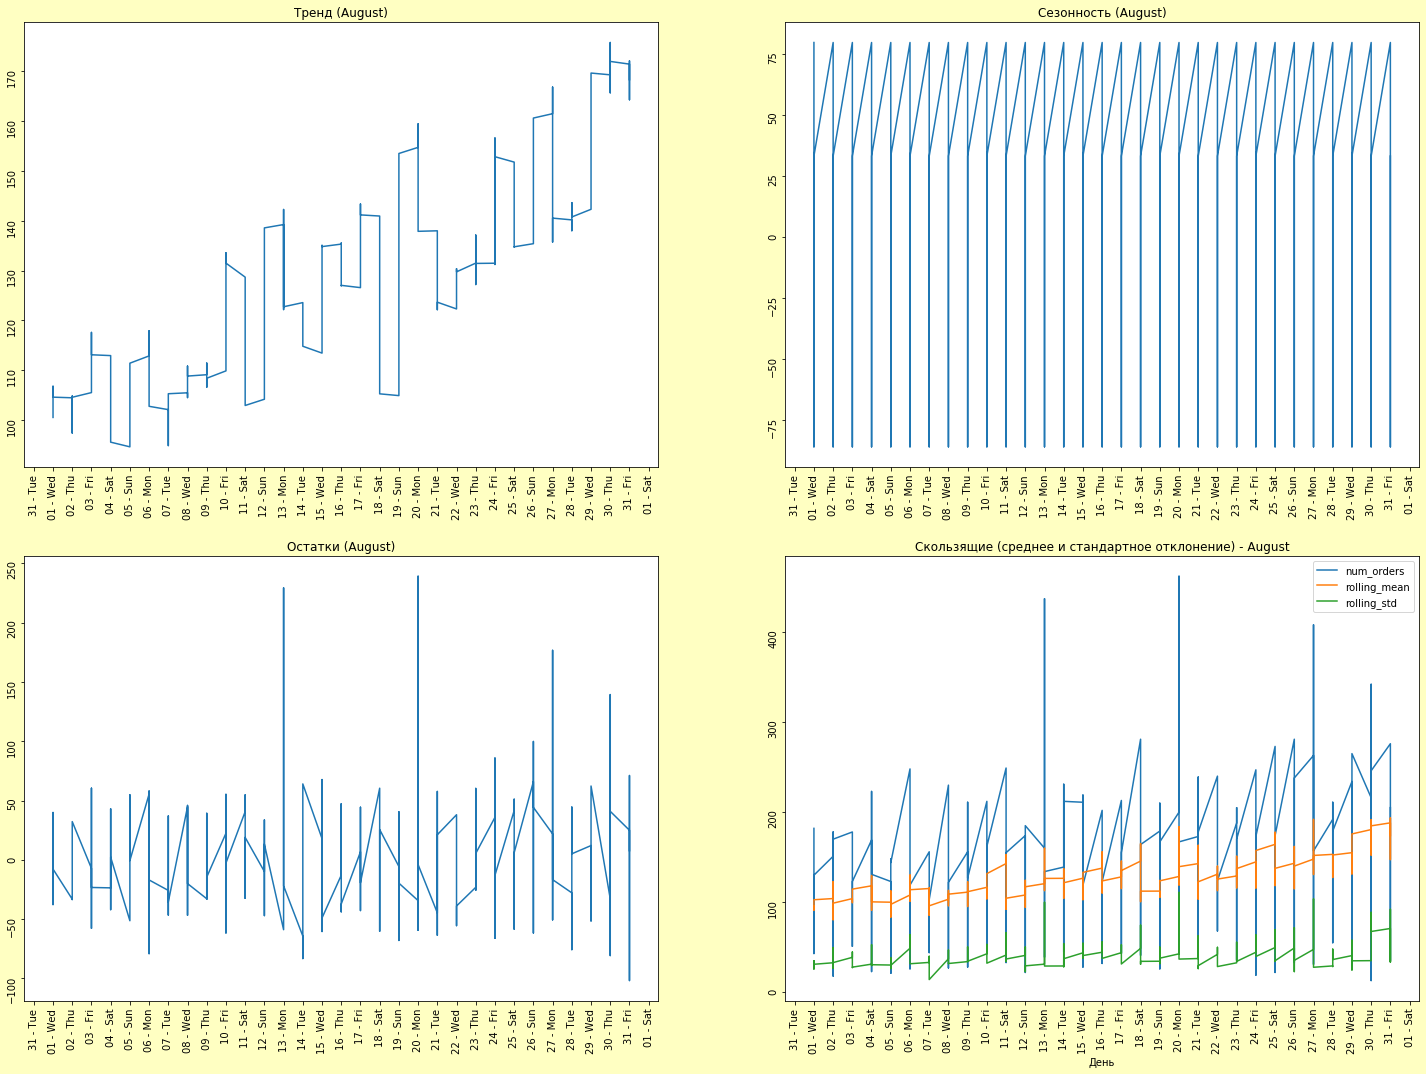

In [14]:
facecolors = [
    'light pink',
    'pale green',
    'beige',
    'pale blue',
    'light gray',
    'cream'
]
for i in range(3,9):
    print('---------------------------------------------Графики для месяца: ','\033[1m',calendar.month_name[i],'\033[0m','--------------------------------------')
    taxi_short  = taxi[taxi.index.month == i].copy()
    decomposed_short = seasonal_decompose(taxi_short)
    x = taxi_short.index.date 
    date_form = mdates.DateFormatter("%d - %a")
    
    fig,((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows = 2, ncols = 2, figsize = (25,18), facecolor ='xkcd:'+facecolors[i-3] )
    l1 = ax1.plot(x, decomposed_short.trend)
    ax1.set_title('Тренд ('+calendar.month_name[i]+')')
    ax1.xaxis.set_major_formatter(date_form)
    ax1.xaxis.set_major_locator(mdates.DayLocator(interval=1))
    ax1.tick_params(labelrotation = 90)

    
    l2 = ax2.plot(x, decomposed_short.seasonal)
    ax2.set_title('Сезонность ('+calendar.month_name[i]+')')
    ax2.xaxis.set_major_formatter(date_form)
    ax2.xaxis.set_major_locator(mdates.DayLocator(interval=1))
    ax2.tick_params(labelrotation = 90)

    l3 = ax3.plot(x, decomposed_short.resid)
    ax3.set_title('Остатки ('+calendar.month_name[i]+')')
    ax3.xaxis.set_major_formatter(date_form)
    ax3.xaxis.set_major_locator(mdates.DayLocator(interval=1))
    ax3.tick_params(labelrotation = 90)


    taxi_short['rolling_mean'] = taxi_short['num_orders'].rolling(15).mean()
    taxi_short['rolling_std'] = taxi_short['num_orders'].rolling(15).std()
    
    l4 = ax4.plot(x,taxi_short)
    ax4.set_title('Скользящие (среднее и стандартное отклонение) - '+ calendar.month_name[i])
    ax4.set_xlabel('День')
    ax4.xaxis.set_major_formatter(date_form)
    ax4.xaxis.set_major_locator(mdates.DayLocator(interval=1))
    ax4.tick_params(labelrotation = 90)
    labels = ['num_orders','rolling_mean','rolling_std']
    ax4.legend([l4], labels=labels,
           loc="upper right")

    plt.show()


<b>Вывод</b><br>
В <b>марте</b> можно видеть резкий рост тренда по пятницам и в выходные и праздничные дни: что естественно, потому что именно в эти дни, как правило, больше причин не садиться за руль. В понеделльник - вторник в целом спрос падает, но со среды начинает постепенно расти. В целом в марте тренд просто то растет, то падает в течение всего месяца, общей тенденции к увеличению или уменьшению не наблюдается. Наблюдается ежедневная сезонность. Остатки ведут себя непредсказуемо. Наиболее высокие колебания скользящего стандартного отклонения наблюдаются возле периодов сильных колебаний остатков <br>
В <b>апреле</b> наблюдается резкий рост тренда по пятницам и понедельникам (вероятно, понедельник больше всего располагает ехать с комфортом, либо после выходных есть причина не садиться за руль), по субботам тренд немного падает, в воскреcенье падает сильно. В вторник также наблюдается довольно резкое падение, со среды - постепенный рост. В целом наблюдается рост тренда к концу месяца. Наблюдается ежедневная сезонность. Остатки ведут себя непредсказуемо. Наиболее высокие колебания скользящего стандартного отклонения наблюдаются возле периодов сильных колебаний остатков<br>
В <b>мае</b> наблюдается резкий рост тренда в праздничные дни, а также в пятницу и в понедельник, в субботу и воскресенье, тренд падает, во вторник - вновь падение и со среды постепенный рост. В целом тренд в мае медленно растет. Наблюдается ежедневная сезонность. Остатки ведут себя непредсказуемо.Наиболее высокие колебания скользящего стандартного отклонения наблюдаются возле периодов сильных колебаний остатков<br>
В <b>июне</b> довольно выражен общий рост тренда, а также резкие скачки в пятницу, небольшой рост - в среду, в четверг снова падение. Наблюдается ежедневная сезонность. Остатки ведут себя непредсказуемо. Колебания скользящего стандартного отклонения достаточно слабые, наиболее заметные колебания - рядом с местами сильных колебаний остатков<br>
В <b>июле</b> значительно больше чем в июне выражен общий рост тренда, заметны сильные скачки в пятницу и воскресенье (очевидно, это как-то связано с перемещениями на выходные), небольшой рост - в среду, в четверг снова падение.  Наблюдается ежедневная сезонность. Остатки ведут себя непредсказуемо. Колебания скользящего стандартного отклонения достаточно слабые, наиболее заметные колебания - рядом с местами сильных колебаний остатков<br>
В <b>августе</b> наблюдается очень выраженный рост тренда к концу месяца, , заметны сильные скачки в пятницу и воскресенье, небольшой рост - в среду, в четверг снова падение.  Наблюдается ежедневная сезонность. Остатки ведут себя непредсказуемо. Колебания скользящего стандартного отклонения достаточно слабые, наиболее заметные колебания - рядом с местами сильных колебаний остатков<br>
<br>
Можно заметить ежемесячный общий рост тренда (заметное исключение составляет апрель -  в марте и мае рост был более слабым, потом снова стал расти): вероятно, это связано с общей тенденцией к повышению спроса на такси (которая также зависит от многих факторов, например, от конкретного города: в Москве, например, в связи с проводимой политикой по снижению использования личных автомобилей в городе, либо в связи с тем, что цены на такси стали более приемлемыми (рост рынка конкурентов)), а также "летней расслабленностью". В каждом месяце заметны колебания тренда возле выходных дней (особенно в пятницу), а также определенный рост тренда начиная со среды (иногда с падением в четверг, иногда - с ростом). В каждом месяце видна ежедневная цикличность, а также заметны колебаниия скользящего среднего и стандартного рядом с периодами колебания остатков, что говорит о их достаточно высоком влиянии на значение скользящих величин. 

<h3>Влияние сдвига на тренд</h3>

In [15]:
taxi_shift = taxi.copy()

taxi_shift['num_orders'] = taxi['num_orders'] - taxi['num_orders'].shift()
taxi_shift_roll = taxi_shift.copy()

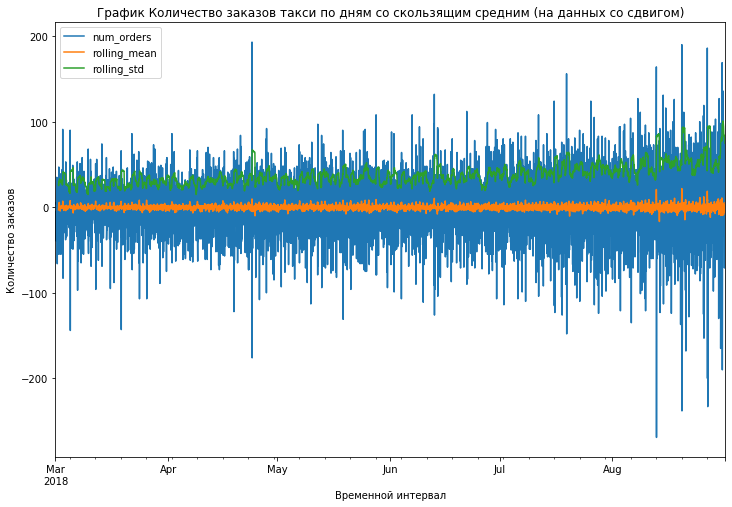

In [16]:
taxi_shift_roll['rolling_mean'] = taxi_shift_roll['num_orders'].rolling(20).mean()
taxi_shift_roll['rolling_std'] = taxi_shift_roll['num_orders'].rolling(20).std()
print_plot(taxi_shift_roll,'Количество заказов такси по дням со скользящим средним (на данных со сдвигом)')

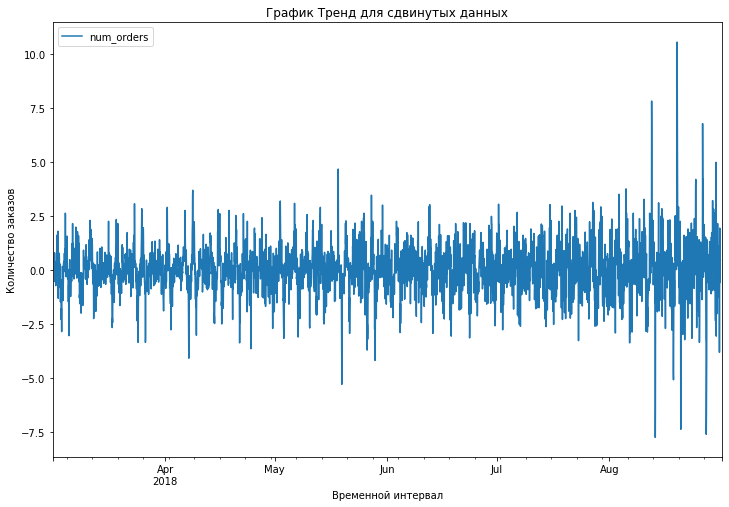

In [17]:
taxi_shift = taxi_shift.dropna()
decomposed_shift = seasonal_decompose(taxi_shift)
print_plot(decomposed_shift.trend,'Тренд для сдвинутых данных')


<b>Вывод</b><br>
Можно видеть, что после вычисления разностей временного ряда, скользящее среднее приблизилось к нулю, а скользящее стандартное отклонение стало более стабильным, тренд -линейным. Используем разности временного ряда в построении моделей

## Обучение

<h3>Подготовка данных</h3>

Напишем функцию по созданию новых признаков:
<ul>
<li>В выборке у нас данные одного года: крайне маловероятно, что это будет полезно для обучения нашей модели</li>
<li>Ранее мы видели, что в данных присутствует тренд на рост количества заказов (как в целом, так и помесячно), а также некоторая зависимость от дней недели и праздников: нам могут быть полезны следующие признаки:
    <ul>
    <li>месяц: количество заказов и тренд растет в каждом месяце</li>
    <li>День - особенно актуально, если учитывать, что в большинстве месяцев тренд возрастает в течение всего месяца</li>
    <li>День недели - поведение тренда во все месяцы зависит от </li>
    <li>Отстающие значения временного ряда</li>
    <li>Скользящее среднее</li>
    </ul>
</li>
</ul>

In [18]:
def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data

taxi = taxi.dropna()
taxi = make_features(taxi, 20,8)
print(taxi.info())


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 25 columns):
num_orders      4416 non-null int64
month           4416 non-null int64
day             4416 non-null int64
dayofweek       4416 non-null int64
lag_1           4415 non-null float64
lag_2           4414 non-null float64
lag_3           4413 non-null float64
lag_4           4412 non-null float64
lag_5           4411 non-null float64
lag_6           4410 non-null float64
lag_7           4409 non-null float64
lag_8           4408 non-null float64
lag_9           4407 non-null float64
lag_10          4406 non-null float64
lag_11          4405 non-null float64
lag_12          4404 non-null float64
lag_13          4403 non-null float64
lag_14          4402 non-null float64
lag_15          4401 non-null float64
lag_16          4400 non-null float64
lag_17          4399 non-null float64
lag_18          4398 non-null float64
lag_19          4397 

Проверим корреляцию признаков между собой:

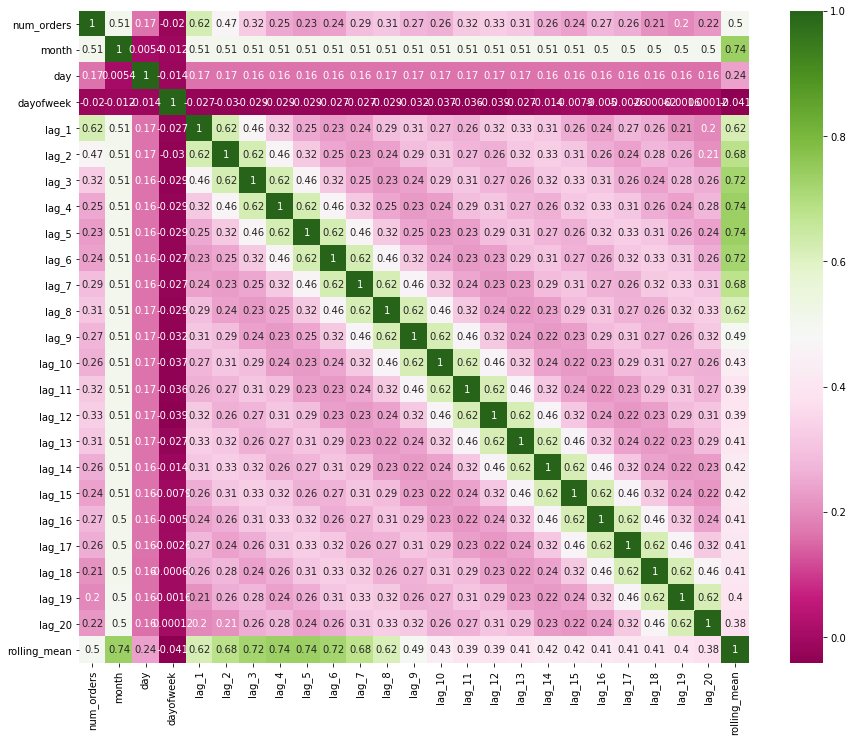

In [19]:
figure = plt.figure(figsize=(15,12))
sns.heatmap(taxi.corr(method='pearson'),annot = True,cmap= 'PiYG' )

Можно видеть, что в целом между собой признаки коррелируют слабо (исключение составляет признаки month и rolling_mean - у них достаточно высокие коэффициенты корреляции со всеми лагами, между собой и с целевым признаком. При увеличении скользящего окна корреляция между month и rolling_mean возрастает). Возможно,выская корреляция между month и всеми остальными признаками обусловлена достаточно малым количеством значений в столбце month (данные всего за полгода), а корреляция со скользящим средним обусловлена самим понятием скользящего среднего и размером скользящего окна - 8 (как раз у первых 8 лагов наибольшая корреляция со скользящим средним). Корреляция лагов между собой достаточно закономерна. В целом, самая высокая корреляция с целевым признаком у month, lag_1(что очевидно, это всего лишь смещение на 1 позицию) и rolling_mean.

Удалим образовавшиеся пропуски

In [20]:
print('Доля строк с пропущенными значениями: ',sum(taxi.apply(lambda x: sum(x.isnull().values), axis = 1)>0)/taxi.shape[0])
taxi = taxi.dropna()
print('Пропущенные значения удалены')

Доля строк с пропущенными значениями:  0.004528985507246377
Пропущенные значения удалены


Разобьем выборку на обучающую и тестовую:

In [21]:
def make_train_test(data,ts,data_name):
    train, test = train_test_split(data, shuffle=False, test_size=ts)
    train_features = train.drop('num_orders',axis = 1)
    train_target = train['num_orders']
    test_features = test.drop('num_orders',axis = 1)
    test_target = test['num_orders']
    print('Результат разбиения на обучающую и тестувую выборку для датасета ',data_name)
    print('Выборка разбита на тестовую и обучающую')
    print('Размер обучающей выборки: ',train.shape)
    print('Временные границы обучающей выборки: ', train.index.min(),' - ', train.index.max())
    print('Размер тестовой выборки: ',test.shape)
    print('Временные границы тестовой выборки: ', test.index.min(),' - ', test.index.max())
    print('-----------------------------------------------------------------------------------')
    return train_features, train_target, test_features, test_target

taxi_train_features,taxi_train_target, taxi_test_features, taxi_test_target = make_train_test(taxi,0.1,'TAXI')
#taxi_train_features_ohe,taxi_train_target_ohe, taxi_test_features_ohe, taxi_test_target_ohe = make_train_test(taxi_ohe,0.1,'TAXI OHE')

Результат разбиения на обучающую и тестувую выборку для датасета  TAXI
Выборка разбита на тестовую и обучающую
Размер обучающей выборки:  (3956, 25)
Временные границы обучающей выборки:  2018-03-01 20:00:00  -  2018-08-13 15:00:00
Размер тестовой выборки:  (440, 25)
Временные границы тестовой выборки:  2018-08-13 16:00:00  -  2018-08-31 23:00:00
-----------------------------------------------------------------------------------


<h3>Обучение моделей и подбор гиперпараметров</h3>

Создадим датасет для сравнения моделей

In [22]:
def add_to_model_types_compare(mtc,mod_name,best_params,best_scores,time):
    mtc = mtc.append({'model_name':mod_name,'best_params':best_params,'best train score':best_scores,'fit_time':time},ignore_index = True)
    display(mtc)
    return mtc
model_types_compare = pd.DataFrame()

Напишем функцию для поиска лучшей модели. Для корректного разбиения датасета на подвыборки для кросс-валидации используем класс TimeSeriesSplit: 

In [23]:
def find_best_model(model,params,features_train,target_train,mtc,mod_name,mod_lib,cat_features):
    grd = GridSearchCV(estimator = model, param_grid = params, 
                               cv = tscv, scoring = 'neg_mean_squared_error')
    if mod_lib == 'CB':
        grd.fit(features_train, target_train,cat_features = cat_features)
    elif mod_lib == 'SL':
        grd.fit(features_train, target_train)
    elif mod_lib == 'LGBM':
        grd.fit(features_train, target_train,categorical_feature = 'auto')
    bs = np.sqrt((-1)*grd.best_score_)
    bp = grd.best_params_
    est = grd.best_estimator_
    time = grd.refit_time_
    mtc = add_to_model_types_compare(mtc,mod_name,bp,bs,time)
    return mtc,est,bp

tscv = TimeSeriesSplit(n_splits=3)

<h4>DecisionTree</h4>

In [24]:
dec_tree = DecisionTreeRegressor()
depth_list = [i for i in range(1,10)]
params = {'max_depth':depth_list,'random_state':[RANDOM_STATE]}
model_types_compare ,best_DT,best_DT_BP= find_best_model(dec_tree,params,taxi_train_features,taxi_train_target,model_types_compare,'DecisionTree','SL',[])


,best train score,best_params,fit_time,model_name
0,35.906213,"{'max_depth': 6, 'random_state': 42}",0.032739,DecisionTree


In [25]:
best_DT.get_params()

{'criterion': 'mse',
 'max_depth': 6,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': False,
 'random_state': 42,
 'splitter': 'best'}

Ниалучший результат для дерева решений достигнут при значении max_depth = 6. Сравним полученные результаты с другими моделями и протестируем ниже.

<h4>RandomForestRegressor</h4>

In [26]:
estim_list = [i for i in range(1,20,5)]
depth_list = [i for i in range(1,15)]
params = {'n_estimators':estim_list, 'max_depth':depth_list,'random_state':[RANDOM_STATE]}
rfc = RandomForestRegressor()    
model_types_compare, best_RF,best_RF_BP = find_best_model(rfc,params,taxi_train_features,taxi_train_target, model_types_compare,'RandomForest','SL',[])


,best train score,best_params,fit_time,model_name
0,35.906213,"{'max_depth': 6, 'random_state': 42}",0.032739,DecisionTree
1,31.627520,"{'max_depth': 14, 'n_estimators': 16, 'random_...",0.858144,RandomForest


In [27]:
best_RF.get_params()

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': 14,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 16,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

Наилучшее значение на модели случайного леса достигнуто при max_depth = 14 и n_estimators = 16. Полученное значение RMSE значительно лучше, чем у модели дерева решений, однако время обучения немного выше. Сравним полученные результаты с другими моделями и протестируем ниже.

<h4>LinearRegression</h4>

In [28]:
params = {'fit_intercept':[True,False]}
lr = LinearRegression() 
model_types_compare, best_LR,best_LR_BP = find_best_model(lr,params, taxi_train_features,taxi_train_target,model_types_compare,'Linear Regression','SL',[])


,best train score,best_params,fit_time,model_name
0,35.906213,"{'max_depth': 6, 'random_state': 42}",0.032739,DecisionTree
1,31.627520,"{'max_depth': 14, 'n_estimators': 16, 'random_...",0.858144,RandomForest
2,31.697333,{'fit_intercept': False},0.005532,Linear Regression


In [29]:
best_LR.get_params()

{'copy_X': True, 'fit_intercept': False, 'n_jobs': None, 'normalize': False}

Наилучший результат линейной регрессии достигнут на модели без свободного члена. Полученный результат сопоставим по качеству с результатом случайного леса, однако скорость обученпия намного выше.  Сравним полученные результаты с другими моделями и протестируем ниже.

<h4>Lasso</h4>

In [30]:
params = {'alpha':[0.05,0.08,0.1,0.25,0.5,0.55,0.6,0.65,0.7,0.75,0.8,1],'fit_intercept':[True,False],'random_state':[RANDOM_STATE]}
ls = Lasso() 
model_types_compare, best_LS,best_LS_BP = find_best_model(ls,params, taxi_train_features,taxi_train_target,model_types_compare,'Lasso','SL',[])


,best train score,best_params,fit_time,model_name
0,35.906213,"{'max_depth': 6, 'random_state': 42}",0.032739,DecisionTree
1,31.627520,"{'max_depth': 14, 'n_estimators': 16, 'random_...",0.858144,RandomForest
2,31.697333,{'fit_intercept': False},0.005532,Linear Regression
3,31.698949,"{'alpha': 0.05, 'fit_intercept': False, 'rando...",2.515400,Lasso


In [31]:
best_LS.get_params()

{'alpha': 0.05,
 'copy_X': True,
 'fit_intercept': False,
 'max_iter': 1000,
 'normalize': False,
 'positive': False,
 'precompute': False,
 'random_state': 42,
 'selection': 'cyclic',
 'tol': 0.0001,
 'warm_start': False}

Наилучший результат модели Лассо достигнут при значении alpha = 0.05 и построении модели без свободного члена. Полученный результат близок к результату линейной регресси, совсем немного хуже.  Сравним полученные результаты с другими моделями и протестируем ниже.

<h4>Ridge</h4>

In [32]:
params = {'alpha':[16,18,20,25,30,35,40,45],'fit_intercept':[True,False],'random_state':[RANDOM_STATE]}
rg = Ridge() 
model_types_compare, best_RG,best_RG_BP = find_best_model(rg,params, taxi_train_features,taxi_train_target,model_types_compare,'Ridge','SL',[])


,best train score,best_params,fit_time,model_name
0,35.906213,"{'max_depth': 6, 'random_state': 42}",0.032739,DecisionTree
1,31.627520,"{'max_depth': 14, 'n_estimators': 16, 'random_...",0.858144,RandomForest
2,31.697333,{'fit_intercept': False},0.005532,Linear Regression
3,31.698949,"{'alpha': 0.05, 'fit_intercept': False, 'rando...",2.515400,Lasso
4,31.695583,"{'alpha': 25, 'fit_intercept': False, 'random_...",0.009257,Ridge


In [33]:
best_RG.get_params()

{'alpha': 25,
 'copy_X': True,
 'fit_intercept': False,
 'max_iter': None,
 'normalize': False,
 'random_state': 42,
 'solver': 'auto',
 'tol': 0.001}

Наилучшее значение гребневой регрессии достигнуто на модели без свободных членов со значением параметра alpha = 25. Данное значение пока самое низкое из всех линейных моделей, однако оно незначительно ниже результатов лассо и линейной регрессии.  Сравним полученные результаты с другими моделями и протестируем ниже.

<h4>ElasticNet</h4>

In [34]:
params = {'alpha':[0.1,0.2,0.3,0.5,0.75,0.8,0.85],'l1_ratio':[0,1,0,2,0.5,0.75,1,1.5,2,3],'fit_intercept':[True,False],'random_state':[RANDOM_STATE]}
en = ElasticNet() 
model_types_compare, best_EN,best_EN_BP = find_best_model(en,params, taxi_train_features,taxi_train_target,model_types_compare,'ElasticNet','SL',[])


,best train score,best_params,fit_time,model_name
0,35.906213,"{'max_depth': 6, 'random_state': 42}",0.032739,DecisionTree
1,31.627520,"{'max_depth': 14, 'n_estimators': 16, 'random_...",0.858144,RandomForest
2,31.697333,{'fit_intercept': False},0.005532,Linear Regression
3,31.698949,"{'alpha': 0.05, 'fit_intercept': False, 'rando...",2.515400,Lasso
4,31.695583,"{'alpha': 25, 'fit_intercept': False, 'random_...",0.009257,Ridge
5,31.700796,"{'alpha': 0.1, 'fit_intercept': False, 'l1_rat...",1.693682,ElasticNet


In [35]:
best_EN.get_params()

{'alpha': 0.1,
 'copy_X': True,
 'fit_intercept': False,
 'l1_ratio': 1,
 'max_iter': 1000,
 'normalize': False,
 'positive': False,
 'precompute': False,
 'random_state': 42,
 'selection': 'cyclic',
 'tol': 0.0001,
 'warm_start': False}

Наилучшее значение эластичной сети достигнуто при значении alpha =0.1 и l1_ratio = 1, fit_intercept = False. Все линейные модели дали очень похожие между собой результаты, однако здесь значение RMSE самое высокое из линейных моделей. Значение RMSE на случайном лесе по-прежнему самое низкое.  Сравним полученные результаты с другими моделями и протестируем ниже.

<h4>LinearSVR</h4>

In [36]:
params = {'C':[0.05,0.1,0.3,0.5,1,2,3,4,5,6,6.8,7,7.2,7,5],'fit_intercept':[True,False],'random_state':[RANDOM_STATE]}
svr = LinearSVR() 
model_types_compare, best_SVR,best_SVR_BP = find_best_model(svr,params, taxi_train_features,taxi_train_target,model_types_compare,'LinearSvr','SL',[])


,best train score,best_params,fit_time,model_name
0,35.906213,"{'max_depth': 6, 'random_state': 42}",0.032739,DecisionTree
1,31.627520,"{'max_depth': 14, 'n_estimators': 16, 'random_...",0.858144,RandomForest
2,31.697333,{'fit_intercept': False},0.005532,Linear Regression
3,31.698949,"{'alpha': 0.05, 'fit_intercept': False, 'rando...",2.515400,Lasso
4,31.695583,"{'alpha': 25, 'fit_intercept': False, 'random_...",0.009257,Ridge
5,31.700796,"{'alpha': 0.1, 'fit_intercept': False, 'l1_rat...",1.693682,ElasticNet
6,32.260354,"{'C': 0.1, 'fit_intercept': True, 'random_stat...",0.652096,LinearSvr


In [37]:
 best_SVR.get_params()

{'C': 0.1,
 'dual': True,
 'epsilon': 0.0,
 'fit_intercept': True,
 'intercept_scaling': 1.0,
 'loss': 'epsilon_insensitive',
 'max_iter': 1000,
 'random_state': 42,
 'tol': 0.0001,
 'verbose': 0}

Модель на опорных векторах дала относительно низкий результат при достаточно длительном времени обучения

<h4>CatBoostRegressor</h4>

In [38]:
cat_features=[]
params = {'learning_rate':[0.05,0.1,0.18,0.2,0.21,0.22,0.23,0.25,0.3,0.4],'n_estimators':[80,85,90,100,110,120,130,140,150,160,170],'random_seed':[RANDOM_STATE],'verbose':[70000]}
cbc = CatBoostRegressor()

model_types_compare, best_CBC,best_CBC_BP = find_best_model(cbc,params, taxi_train_features,taxi_train_target,model_types_compare,'CatBoostRegressor','CB',cat_features)


0:	learn: 28.7979020	total: 49.3ms	remaining: 3.89s
79:	learn: 17.1376033	total: 833ms	remaining: 0us
0:	learn: 31.4809046	total: 2.86ms	remaining: 226ms
79:	learn: 19.8207477	total: 1.31s	remaining: 0us
0:	learn: 33.3581518	total: 2.67ms	remaining: 211ms
79:	learn: 22.0245055	total: 2.02s	remaining: 0us
0:	learn: 28.7979020	total: 1.68ms	remaining: 141ms
84:	learn: 16.8854402	total: 974ms	remaining: 0us
0:	learn: 31.4809046	total: 3.19ms	remaining: 268ms
84:	learn: 19.5553863	total: 1.48s	remaining: 0us
0:	learn: 33.3581518	total: 11.6ms	remaining: 974ms
84:	learn: 21.8290010	total: 2.58s	remaining: 0us
0:	learn: 28.7979020	total: 3.65ms	remaining: 325ms
89:	learn: 16.6684700	total: 1.08s	remaining: 0us
0:	learn: 31.4809046	total: 2.1ms	remaining: 187ms
89:	learn: 19.3251826	total: 1.59s	remaining: 0us
0:	learn: 33.3581518	total: 2.43ms	remaining: 216ms
89:	learn: 21.6318329	total: 2.23s	remaining: 0us
0:	learn: 28.7979020	total: 3.02ms	remaining: 299ms
99:	learn: 16.2124797	total: 1.

,best train score,best_params,fit_time,model_name
0,35.906213,"{'max_depth': 6, 'random_state': 42}",0.032739,DecisionTree
1,31.627520,"{'max_depth': 14, 'n_estimators': 16, 'random_...",0.858144,RandomForest
2,31.697333,{'fit_intercept': False},0.005532,Linear Regression
3,31.698949,"{'alpha': 0.05, 'fit_intercept': False, 'rando...",2.515400,Lasso
4,31.695583,"{'alpha': 25, 'fit_intercept': False, 'random_...",0.009257,Ridge
5,31.700796,"{'alpha': 0.1, 'fit_intercept': False, 'l1_rat...",1.693682,ElasticNet
6,32.260354,"{'C': 0.1, 'fit_intercept': True, 'random_stat...",0.652096,LinearSvr
7,30.515918,"{'learning_rate': 0.3, 'n_estimators': 80, 'ra...",4.806712,CatBoostRegressor


In [39]:
best_CBC.get_params()

{'loss_function': 'RMSE',
 'learning_rate': 0.3,
 'n_estimators': 80,
 'random_seed': 42,
 'verbose': 70000}

Модель CatBoostRegressor дала самое низкое значение метрики RMSE, однако время обучения самое длительное, но приемлемое. Осталось сравнить с резултатом модели LGBMRegressor, а также протестировать.

<h4>LGBMRegressor</h4>

In [40]:
params = {'learning_rate':[0.01,0.02,0.05,0.08,0.1,0.15,0.2,0.3],'n_estimators':[25,28,30,32,35,40,45,47,50,53,55,60,65,70],'random_state':[RANDOM_STATE]}
lgbm = LGBMRegressor()
model_types_compare, best_LGBM,best_CBC_LGBM = find_best_model(lgbm,params, taxi_train_features,taxi_train_target,model_types_compare,'LGBMRegressor','LGBM',cat_features)


,best train score,best_params,fit_time,model_name
0,35.906213,"{'max_depth': 6, 'random_state': 42}",0.032739,DecisionTree
1,31.627520,"{'max_depth': 14, 'n_estimators': 16, 'random_...",0.858144,RandomForest
2,31.697333,{'fit_intercept': False},0.005532,Linear Regression
3,31.698949,"{'alpha': 0.05, 'fit_intercept': False, 'rando...",2.515400,Lasso
4,31.695583,"{'alpha': 25, 'fit_intercept': False, 'random_...",0.009257,Ridge
5,31.700796,"{'alpha': 0.1, 'fit_intercept': False, 'l1_rat...",1.693682,ElasticNet
6,32.260354,"{'C': 0.1, 'fit_intercept': True, 'random_stat...",0.652096,LinearSvr
7,30.515918,"{'learning_rate': 0.3, 'n_estimators': 80, 'ra...",4.806712,CatBoostRegressor
8,31.371272,"{'learning_rate': 0.1, 'n_estimators': 70, 'ra...",1.187292,LGBMRegressor


In [41]:
best_LGBM.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 70,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': 42,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

Модель LGBM дала чуть более высокое значение RMSE, чем CatBoost, однако время обучения намного ниже. Осталось протестировать модели и выбрать лучшую

<b>Вывод</b><br>
Наилучшие результаты дали модели CatBoostRegressor и LGBMRegressor, а также RandomForestRegressor. У всех линейных моделей очень похожие значения RMSE: они отличаются очень незначительно и довольно близки к значению RMSE у RandomFprestRegressor. Самые большие значения RMSE - у моделей опореных векторов и дерева решений. Протестируем модели и выберем лучшую  

## Тестирование

Протестируем пять моделей с наилучшим результатом. Для этого отберем модели с наилучшим результатом

In [42]:
model_types_compare.sort_values(by = 'best train score', ascending = True)

,best train score,best_params,fit_time,model_name
7,30.515918,"{'learning_rate': 0.3, 'n_estimators': 80, 'ra...",4.806712,CatBoostRegressor
8,31.371272,"{'learning_rate': 0.1, 'n_estimators': 70, 'ra...",1.187292,LGBMRegressor
1,31.627520,"{'max_depth': 14, 'n_estimators': 16, 'random_...",0.858144,RandomForest
4,31.695583,"{'alpha': 25, 'fit_intercept': False, 'random_...",0.009257,Ridge
2,31.697333,{'fit_intercept': False},0.005532,Linear Regression
3,31.698949,"{'alpha': 0.05, 'fit_intercept': False, 'rando...",2.515400,Lasso
5,31.700796,"{'alpha': 0.1, 'fit_intercept': False, 'l1_rat...",1.693682,ElasticNet
6,32.260354,"{'C': 0.1, 'fit_intercept': True, 'random_stat...",0.652096,LinearSvr
0,35.906213,"{'max_depth': 6, 'random_state': 42}",0.032739,DecisionTree


Протестируем модели: CatBoostRegressor, LGBMRegressor, RandomForest, Ridge, Linear Regression

Напишем функцию для расчета и вывода результата тестирования

In [43]:
def make_prediction_result(model,features,target, model_name):
    predict = model.predict(features)
    rmse = np.sqrt(mean_squared_error(target, predict))
    print('RMSE на тестовых данных для модели ','\033[1m',model_name,': ',rmse,'\033[0m')
    print('-------------------------------------------------------')

Проведем тестирование:

In [44]:
#CatBoost
make_prediction_result(best_CBC,taxi_test_features,taxi_test_target, 'CatBoostRegressor')
#LGBM
make_prediction_result(best_LGBM,taxi_test_features,taxi_test_target, 'LGBMRegressor')
#RandomForest
make_prediction_result(best_RF,taxi_test_features,taxi_test_target, 'RandomForestRegressor')
#Ridge
make_prediction_result(best_RG,taxi_test_features,taxi_test_target, 'Ridge')
#LinearRegression
make_prediction_result(best_LR,taxi_test_features,taxi_test_target, 'LinearRegression')

RMSE на тестовых данных для модели   CatBoostRegressor :  49.43307801218895 
-------------------------------------------------------
RMSE на тестовых данных для модели   LGBMRegressor :  46.90944173575074 
-------------------------------------------------------
RMSE на тестовых данных для модели   RandomForestRegressor :  51.95868161081754 
-------------------------------------------------------
RMSE на тестовых данных для модели   Ridge :  52.66623846231476 
-------------------------------------------------------
RMSE на тестовых данных для модели   LinearRegression :  52.73136929987596 
-------------------------------------------------------


<b>Вывод:</b><br>
Самое лучшее значение метрики RMSE на тестовых данных у модели LGBMRegressor, у этой же модели второй результат по метрике RMSE на тренировочных данных и относительно низкое время обучения: данную модель можно признать лучшей. <br>
Модель CatBoostRegressor оказалась более склонной к переобучению, поэтому ее лучшей назвать нельзя. <br>
Модели RandomForestRegressor, Ridge, LinearRegression также очень склонны к переобучению и значение метрики RMSE на тестовых данных довольно высокое.